In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
import os
import numpy as np

In [2]:
base_dir = "/media/Data/VBS/VBS_Evaluation/vbse2022/"
dfs = []
for f in os.listdir(base_dir):
    df = pd.read_pickle(f"{base_dir}/{f}")
    dfs.append(df)

dataset = pd.concat(dfs)

## Preprocessing

In [3]:
dataset = dataset.loc[dataset["type"]!="submission"]
dataset = dataset.loc[dataset["category"]!="SUBMIT"]
dataset = dataset.loc[~((dataset["team"]=="CVHunter")&(dataset["category"]=="BROWSING"))]
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace("Temporal CLIP: ","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace("CLIP: ","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace(">","")
dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"] = dataset.loc[((dataset["team"]=="CVHunter")&(dataset["category"]=="TEXT")),"value"].str.replace(":","")
dataset = dataset.loc[dataset["category"]!="BROWSING"]
dataset = dataset.loc[dataset["category"]!="Browsing"]
dataset = dataset.loc[dataset["elapsed_since_task_start_ms"]>=0]

In [4]:
dataset.shape

(4361, 16)

In [5]:
# merge visione temporal querries
visioneTemporal = dataset.loc[((dataset["team"]=="VISIONE")&(dataset["additionals"].str.contains('"queryparameter":"Temporal_')))]
prev_timestamp = 0
newRows = []
visioneNonDuplicate = visioneTemporal.drop_duplicates(subset=["task","team","user","timestamp"])


txtGroupby = visioneTemporal.groupby(["task","team","user","timestamp"]).agg({'value': ' '.join}).reset_index()    

for (idx, row) in txtGroupby.iterrows():    
    visioneNonDuplicate.loc[((visioneNonDuplicate.user==row["user"])&(visioneNonDuplicate.timestamp==row["timestamp"])),"value"] = row["value"]
dataset = dataset.loc[~((dataset["team"]=="VISIONE")&(dataset["additionals"].str.contains('"queryparameter":"Temporal_')))]
dataset = pd.concat([dataset,visioneNonDuplicate])
dataset.shape

(4361, 16)

In [6]:
dataset["QT"] = "None"

In [7]:
dataset["Restricted"] = 0

In [8]:
one_minute_in_ms = 45*1000 # one minute
dataset.loc[dataset["elapsed_since_task_start_ms"] < one_minute_in_ms,"Restricted"] = 1

In [9]:
#dataset.loc[(dataset["Restricted"] == 1) & (dataset["team"] == "vibro3")].sort_values(by='timestamp', ascending=True)

In [10]:
dataset["Sytem"] = "None"

In [11]:
dataset.loc[dataset["team"].str.contains("visione"),"Sytem"] = "visione"
dataset.loc[dataset["team"].str.contains("vibro"),"Sytem"] = "vibro"
dataset.loc[dataset["team"].str.contains("cvhunter"),"Sytem"] = "cvhunter"

In [12]:
dataset[dataset["Sytem"] == "None"]

,shotTimeMs,videoId,rank,timestamp,user,task,team,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,category,type,value,additionals,QT,Restricted,Sytem


#### Data will be grouped as follows


1. Text: jointEmbedding and concept search
2. ODLS: Objectbased- Detection, Localisation and Segmentation
3. Color: Low Level Features and Color Search
4. OCR
5. Image: Image-based Searches 

In [13]:
# Text
dataset.loc[dataset["type"].str.contains("jointEmbedding"),"QT"] = "Text"
dataset.loc[dataset["type"].str.contains("JointEmbedding"),"QT"] = "Text"
dataset.loc[dataset["type"].str.contains("concept"),"QT"] = "Text"
dataset.loc[dataset["value"].str.contains("jointEmbedding"),"QT"] = "Text"

In [14]:
# ODLS
dataset.loc[dataset["type"].str.contains("LocalizedObjectAndColors"),"QT"] = "ODLS"
dataset.loc[dataset["type"].str.contains("semanticSegmentation"),"QT"] = "ODLS"
dataset.loc[dataset["type"].str.contains("numberOfObjects"),"QT"] = "ODLS"

In [15]:
#dataset.loc[dataset["value"].str.contains("color")]

In [16]:
# Sketch
dataset.loc[dataset["value"] == "color" ,"QT"] = "Color"
dataset.loc[dataset["type"].str.contains("dominantColor"),"QT"] = "Color"

In [17]:
# IMAGE
dataset.loc[dataset["category"].str.contains("IMAGE"),"QT"] = "IMAGE"
dataset.loc[dataset["category"].str.contains("Image"),"QT"] = "IMAGE"

In [18]:
# vibro temporal queries
dataset.loc[dataset["category"].str.contains("TEMPORAL"),"QT"] = "TEMPORAL"

In [19]:
dataset[dataset["QT"] == "None"]

,shotTimeMs,videoId,rank,timestamp,user,task,team,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,category,type,value,additionals,QT,Restricted,Sytem


In [20]:
dataset.head()

,shotTimeMs,videoId,rank,timestamp,user,task,team,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,category,type,value,additionals,QT,Restricted,Sytem
0,NaN,NaN,NaN,1668157256566,0,vbse001,visione2,8199.0,83979.0,466.0,466.0,466.0,TEXT,jointEmbedding,A woman holding a steaming mug close to the camera.,"{""subtype"":"""",""queryparameter"":""textualMode=clip,occur=and,simReorder=false""}",Text,1,visione
1,NaN,NaN,NaN,1668157307457,0,vbse001,visione2,59090.0,83979.0,17.0,17.0,17.0,TEXT,jointEmbedding,A woman holding a steaming mug close to the camera.,"{""subtype"":"""",""queryparameter"":""Temporal_query1, textualMode=clip,occur=and,simReorder=false""}",Text,0,visione
2,NaN,NaN,NaN,1668157307457,0,vbse001,visione2,59090.0,83979.0,17.0,17.0,17.0,TEXT,jointEmbedding,chinese lamp,"{""subtype"":"""",""queryparameter"":""Temporal_query2, textualMode=clip,occur=and,simReorder=false""}",Text,0,visione
3,NaN,NaN,NaN,1668157323984,0,vbse001,visione2,75617.0,83979.0,9.0,9.0,9.0,TEXT,jointEmbedding,A woman holding a steaming mug close to the camera.,"{""subtype"":"""",""queryparameter"":""Temporal_query1, textualMode=clip,occur=and,simReorder=false""}",Text,0,visione
4,NaN,NaN,NaN,1668157323984,0,vbse001,visione2,75617.0,83979.0,9.0,9.0,9.0,TEXT,jointEmbedding,"chinese lamp, raining","{""subtype"":"""",""queryparameter"":""Temporal_query2, textualMode=clip,occur=and,simReorder=false""}",Text,0,visione


# Querytype analysis

In [21]:
dataset.groupby(["team", "QT"])[["value"]].count()

value
team      QT             
cvhunter1 IMAGE        25
          Text        482
cvhunter2 IMAGE        97
          Text        242
cvhunter3 IMAGE        75
          Text        233
cvhunter4 IMAGE        51
          Text        174
vibro1    Color         1
          IMAGE       222
          Text        130
vibro2    Color         2
          IMAGE       197
          TEMPORAL     66
          Text         85
vibro3    IMAGE        95
          TEMPORAL     80
          Text        152
vibro4    IMAGE        76
          Text        119
visione1  IMAGE        24
          ODLS        116
          Text        460
visione2  IMAGE         3
          ODLS        157
          Text        287
visione3  IMAGE         4
          ODLS         19
          Text        249
visione4  IMAGE         8
          ODLS        156
          Text        274

In [22]:
dataset.groupby(["Sytem", "QT"])[["value"]].count()

value
Sytem    QT             
cvhunter IMAGE       248
         Text       1131
vibro    Color         3
         IMAGE       590
         TEMPORAL    146
         Text        486
visione  IMAGE        39
         ODLS        448
         Text       1270

In [23]:
dataset.groupby(["Sytem","team", "QT"])[["value"]].count()

value
Sytem    team      QT             
cvhunter cvhunter1 IMAGE        25
                   Text        482
         cvhunter2 IMAGE        97
                   Text        242
         cvhunter3 IMAGE        75
                   Text        233
         cvhunter4 IMAGE        51
                   Text        174
vibro    vibro1    Color         1
                   IMAGE       222
                   Text        130
         vibro2    Color         2
                   IMAGE       197
                   TEMPORAL     66
                   Text         85
         vibro3    IMAGE        95
                   TEMPORAL     80
                   Text        152
         vibro4    IMAGE        76
                   Text        119
visione  visione1  IMAGE        24
                   ODLS        116
                   Text        460
         visione2  IMAGE         3
                   ODLS        157
                   Text        287
         visione3  IMAGE         4
                   ODLS         19
                   Text        249
         visione4  IMAGE         8
                   ODLS        156
                   Text        274

# Some Plots

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
res_data = dataset.loc[(dataset["Restricted"] == 1)]
after_data = dataset.loc[(dataset["Restricted"] == 0)]

In [26]:
res_data.head()

,shotTimeMs,videoId,rank,timestamp,user,task,team,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,rank_shot_margin_5,category,type,value,additionals,QT,Restricted,Sytem
0,NaN,NaN,NaN,1668157256566,0,vbse001,visione2,8199.0,83979.0,466.0,466.0,466.0,TEXT,jointEmbedding,A woman holding a steaming mug close to the camera.,"{""subtype"":"""",""queryparameter"":""textualMode=clip,occur=and,simReorder=false""}",Text,1,visione
5,NaN,NaN,NaN,1668157577798,0,vbse002,visione2,5824.0,NaN,9007.0,inf,inf,TEXT,jointEmbedding,Viewer moving fast backwards on railway tracks.,"{""subtype"":"""",""queryparameter"":""textualMode=clip,occur=and,simReorder=false""}",Text,1,visione
55,NaN,NaN,NaN,1668157948949,0,vbse003,visione2,6372.0,127113.0,247.0,438.0,438.0,TEXT,jointEmbedding,Close-up shot of water waves reflecting the sun.,"{""subtype"":"""",""queryparameter"":""textualMode=clip,occur=and,simReorder=false""}",Text,1,visione
56,NaN,NaN,NaN,1668157983320,0,vbse003,visione2,40743.0,127113.0,162.0,240.0,162.0,Image,globalFeatures,02537/02537_40_1.jpg,"{""subtype"":""sematic similarity (tern)"",""queryparameter"":""simReorder=false""}",IMAGE,1,visione
61,NaN,NaN,NaN,1668158281405,0,vbse004,visione2,6818.0,70056.0,241.0,2888.0,241.0,TEXT,jointEmbedding,A woman having a mobile phone call in bed,"{""subtype"":"""",""queryparameter"":""textualMode=clip,occur=and,simReorder=false""}",Text,1,visione


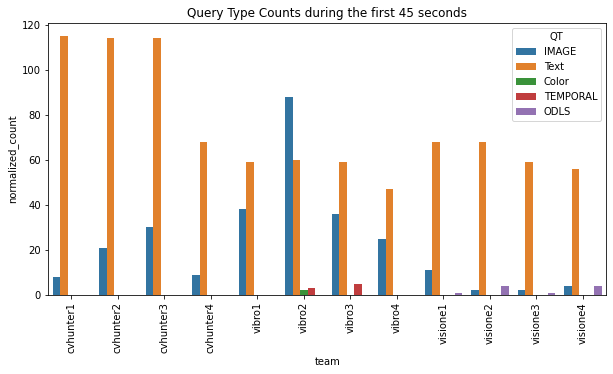

In [27]:
grouped = res_data.groupby(["team", "QT"])[["value"]].count()
normalized = grouped#grouped.div(grouped.groupby('team').transform('sum'))
normalized = normalized.reset_index()
normalized = normalized.rename(columns={'value': 'normalized_count'})

plt.figure(figsize=(10, 5))
# plot the results using seaborn
sns.barplot(x='team', y='normalized_count', hue='QT', data=normalized)
plt.xticks(rotation=90)
# display the plot
plt.title("Query Type Counts during the first 45 seconds")
plt.show()

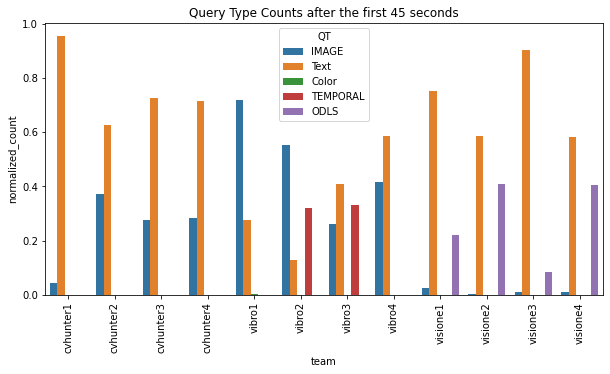

In [28]:
grouped = after_data.groupby(["team", "QT"])[["value"]].count()
normalized = grouped.div(grouped.groupby('team').transform('sum'))
normalized = normalized.reset_index()
normalized = normalized.rename(columns={'value': 'normalized_count'})

plt.figure(figsize=(10, 5))
# plot the results using seaborn
sns.barplot(x='team', y='normalized_count', hue='QT', data=normalized)
plt.xticks(rotation=90)
# display the plot
plt.title("Query Type Counts after the first 45 seconds")
plt.show()

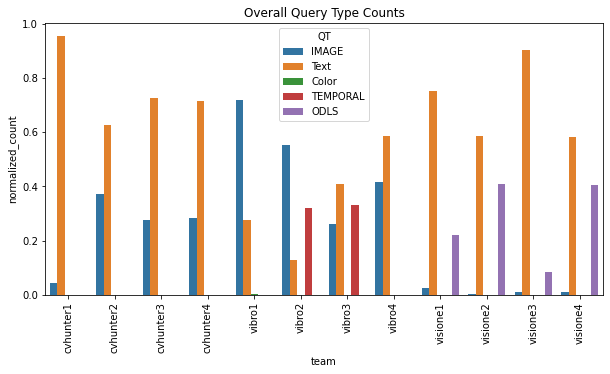

In [29]:
normalized = grouped.div(grouped.groupby('team').transform('sum'))
normalized = normalized.reset_index()
normalized = normalized.rename(columns={'value': 'normalized_count'})

plt.figure(figsize=(10, 5))
# plot the results using seaborn
sns.barplot(x='team', y='normalized_count', hue='QT', data=normalized)
plt.xticks(rotation=90)
# display the plot
plt.title("Overall Query Type Counts")
plt.show()

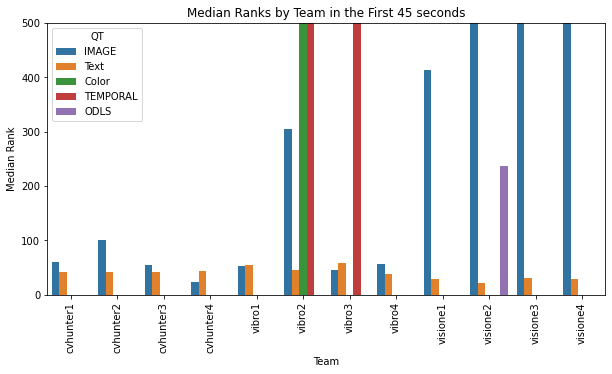

In [30]:
setTo = 20000
medianStats = res_data.replace(np.inf, setTo)
medianStats = medianStats[medianStats['rank_video'] < 10000]
grouped = medianStats.groupby(["team", "QT"])[["rank_video"]].median()

# reset the MultiIndex to columns and rename the columns
grouped = grouped.reset_index()
grouped = grouped.rename(columns={'rank_video': 'mean_rank_video'})

plt.figure(figsize=(10, 5))
# plot the results using seaborn
sns.barplot(x='team', y='mean_rank_video', hue='QT', data=grouped)


# set the title and axis labels
plt.title('Median Ranks by Team in the First 45 seconds')
plt.xlabel('Team')
plt.ylabel('Median Rank')
plt.xticks(rotation=90)
plt.ylim([0, 500])
# display the plot
plt.show()

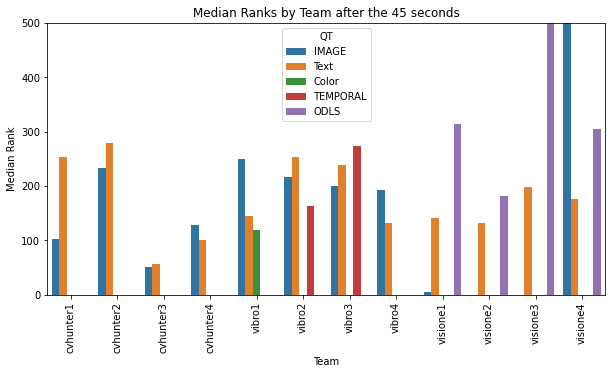

In [31]:
medianStats = after_data.replace(np.inf, setTo)
medianStats = medianStats[medianStats['rank_video'] < 10000]
grouped = medianStats.groupby(["team", "QT"])[["rank_video"]].median()

# reset the MultiIndex to columns and rename the columns
grouped = grouped.reset_index()
grouped = grouped.rename(columns={'rank_video': 'mean_rank_video'})

plt.figure(figsize=(10, 5))
# plot the results using seaborn
sns.barplot(x='team', y='mean_rank_video', hue='QT', data=grouped)


# set the title and axis labels
plt.title('Median Ranks by Team after the 45 seconds')
plt.xlabel('Team')
plt.ylabel('Median Rank')
plt.xticks(rotation=90)
plt.ylim([0, 500])
# display the plot
plt.show()